
# Pitfalls of Permutation Feature Importance (PFI) on the California Housing Dataset

In this example, we illustrate the pitfalls of using permutation feature importance
(PFI) on the California housing dataset.
PFI measures the importance of a variable. However, it does not measure conditional
importance and does not provide statistical control over the risk of making false
discoveries, i.e., the risk of declaring a variable as important when it is not.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from scipy.stats import ttest_1samp
from sklearn.base import clone
from sklearn.compose import TransformedTargetRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, scale

from hidimstat import CPI, PFI
from hidimstat.conditional_sampling import ConditionalSampler

random_seed = 0
rng = np.random.RandomState(random_seed)
n_folds = 2

## Load the California housing dataset and add a spurious feature
The California housing dataset is a regression dataset with 8 features. We add a
spurious feature that is a linear combination of 3 features plus some noise.
The spurious feature does not provide any additional information about the target.



The dataset contains 6879 samples and 10 features.


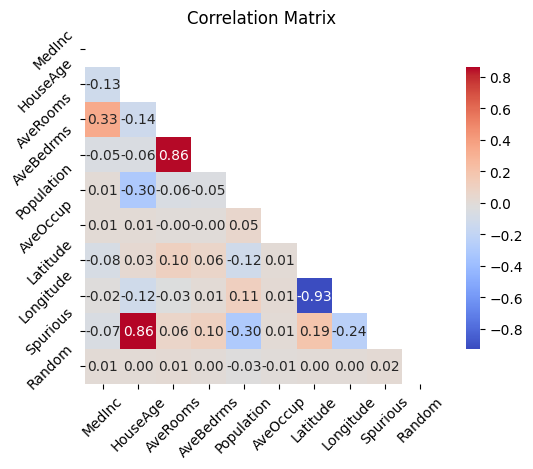

In [2]:
dataset = fetch_california_housing()
X_, y_ = dataset.data, dataset.target
# only use 2/3 of samples to speed up the example
X, _, y, _ = train_test_split(X_, y_, test_size=0.6667, random_state=random_seed, shuffle=True)

redundant_coef = rng.choice(np.arange(X.shape[1]), size=(3,), replace=False)
X_spurious = X[:, redundant_coef].sum(axis=1)
X_spurious += rng.normal(0, scale=np.std(X_spurious) * 0.5, size=X.shape[0])
X_random = rng.normal(0, 0.5, size=X.shape[0])
X = np.hstack([X, X_spurious[:, np.newaxis], X_random[:, np.newaxis]])
feature_names = dataset.feature_names + ["Spurious"] + ["Random"]
print(f"The dataset contains {X.shape[0]} samples and {X.shape[1]} features.")

# Compute the correlation matrix
correlation_matrix = np.corrcoef(X, rowvar=False)

# Plot the lower triangle of the correlation matrix
fig, ax = plt.subplots()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(
    correlation_matrix,
    mask=mask,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    square=True,
    cbar_kws={"shrink": 0.8},
    ax=ax,
)
ax.set_title("Correlation Matrix")
ax.set_yticks(
    np.arange(len(feature_names)) + 0.5, labels=feature_names, fontsize=10, rotation=45
)
ax.set_xticks(
    np.arange(len(feature_names)) + 0.5, labels=feature_names, fontsize=10, rotation=45
)
plt.tight_layout()
plt.show()

## Fit a predictive model
We fit a neural network model to the California housing dataset. PFI is a
model-agnostic method, we therefore illustrate its behavior when using a neural
network model.



In [3]:
fitted_estimators = []
train_scores = []
test_scores = []
# model = TransformedTargetRegressor(
#     regressor=make_pipeline(
#         StandardScaler(),
#         MLPRegressor(
#             random_state=random_seed,
#             hidden_layer_sizes=(32, 16, 8),
#             early_stopping=True,
#             learning_rate_init=0.01,
#             n_iter_no_change=5,
#         ),
#     ),
#     transformer=StandardScaler(),
# )
model = RandomForestRegressor(
    n_estimators=200,
    oob_score=True,
    n_jobs=4,
    random_state=random_seed,
    max_features=1.0,
    min_samples_leaf=20,
)

kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_seed)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model_c = clone(model)

    model_c = model_c.fit(X_train, y_train)
    fitted_estimators.append(model_c)
    y_pred_train = model_c.predict(X_train)
    y_pred_test = model_c.predict(X_test)
    train_scores.append(r2_score(y_train, y_pred_train))
    test_scores.append(r2_score(y_test, y_pred_test))

print(f"Cross-validation R2 score on train: {np.mean(train_scores):.3f} ± {np.std(train_scores):.3f}")
print(f"Cross-validation R2 score on test: {np.mean(test_scores):.3f} ± {np.std(test_scores):.3f}")

Cross-validation R2 score on train: 0.781 ± 0.005
Cross-validation R2 score on test: 0.711 ± 0.009


## Measure the importance of variables using the PFI method
We use the `PermutationFeatureImportance` class to compute the PFI in a cross-fitting
way. We then derive a p-value from importance scores using a one-sample t-test.
As shown in the figure below, the PFI method does not provide valid p-values for
testing conditional importance, as it identifies the spurious feature as important.



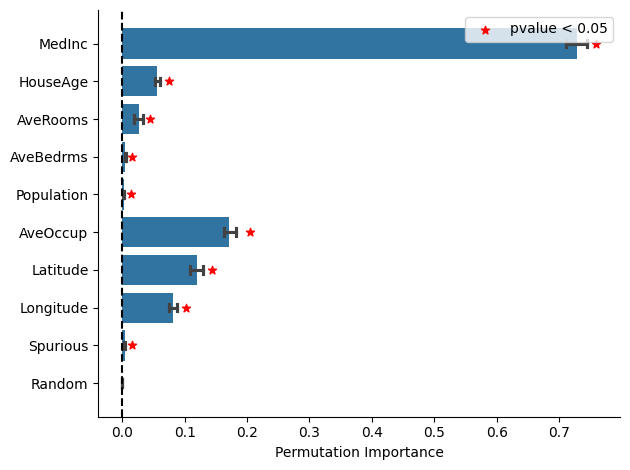

In [28]:
permutation_importances = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model_c = fitted_estimators[i]

    # Compute permutation feature importance
    pfi = PFI(
        model_c,
        n_permutations=50,
        random_state=random_seed,
    )
    pfi.fit(X_test, y_test)

    permutation_importances.append(pfi.importance(X_test, y_test)["importance"])
permutation_importances = np.stack(permutation_importances)
pval_pfi = ttest_1samp(
    permutation_importances, 0.0, axis=0, alternative="greater"
).pvalue


# Define a p-value threshold
pval_threshold = 0.05
# Create a horizontal boxplot of permutation importances
fig, ax = plt.subplots()
sns.barplot(
    permutation_importances,
    orient="h",
    color="tab:blue",
    capsize=0.2,
)
ax.set_xlabel("Permutation Importance")
# Add asterisks for features with p-values below the threshold
for i, pval in enumerate(pval_pfi):
    if pval < pval_threshold:
        ax.scatter(
            np.max(permutation_importances[:, i]) + 0.01,
            i,
            color="red",
            marker="*",
            label="pvalue < 0.05" if i == 0 else "",
        )
ax.axvline(x=0, color="black", linestyle="--")
# Add legend for asterisks
ax.legend(loc="upper right")
sns.despine(ax=ax)
ax.set_yticks(range(len(feature_names)), labels=feature_names)
fig.tight_layout()
plt.show()

While the most important variables identified by PFI are plausible, such as the
geographic coordinates or the median income of the block group, it is not robust to
the presence of spurious features and misleadingly identifies the spurious feature as
important.



## A valid alternative: Condional permutation importance
The `ConditionalPermutationFeatureImportance` class computes permutations of the feature of
interest while conditioning on the other features. In other words, it shuffles the
intrinsic information of the feature of interest while leaving the information that is
explained by the other features unchanged. This method is valid for testing conditional
importance. As shown below, it does not identify the spurious feature as important.



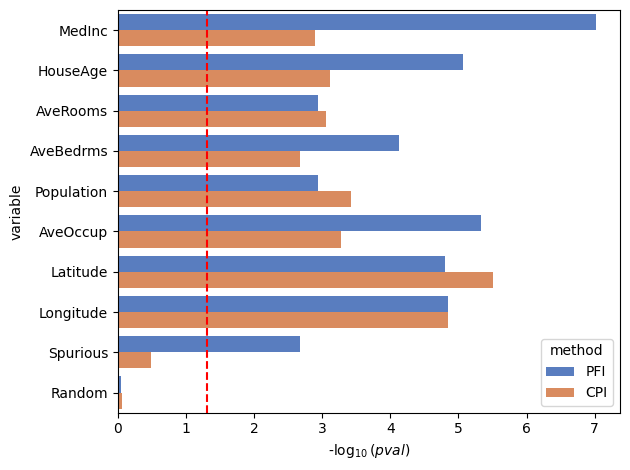

In [29]:
conditional_importances = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model_c = fitted_estimators[i]

    # Compute conditional permutation feature importance
    cpi = CPI(
        model_c,
        imputation_model_continuous=RidgeCV(alphas=np.logspace(-3, 3, 5)),
        random_state=random_seed,
        n_jobs=5,
    )
    cpi.fit(X_test, y_test)

    conditional_importances.append(cpi.importance(X_test, y_test)["importance"])

conditional_importances = np.stack(conditional_importances)
cpi_pval = ttest_1samp(
    conditional_importances, 0.0, axis=0, alternative="greater"
).pvalue


df_pval = pd.DataFrame(
    {
        "pval": np.concatenate([pval_pfi, cpi_pval]),
        "method": ["PFI"] * len(pval_pfi) + ["CPI"] * len(cpi_pval),
        "variable": feature_names * 2,
        "log_pval": -np.concatenate([np.log10(pval_pfi), np.log10(cpi_pval)]),
    }
)


fig, ax = plt.subplots()
sns.barplot(
    data=df_pval,
    x="log_pval",
    y="variable",
    hue="method",
    palette="muted",
    ax=ax,
)
ax.axvline(x=-np.log10(pval_threshold), color="red", linestyle="--")
ax.set_xlabel("-$\\log_{10}(pval)$")
plt.tight_layout()
plt.show()

Contrary to PFI, CPI does not identify the spurious feature as important.



In [4]:
# Store all results
mdi_data = []
umdi_data = []
pfi_data = []
cpi_data = []
pval_data = []

n_features = len(feature_names)

# Loop over all max_features from 1 to 10
for mf in range(1, n_features + 1):
    all_fold_mdi = []
    all_fold_umdi = []
    all_fold_pfi = []
    all_fold_cpi = []

    for i, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Clone model and set max_features
        model = clone(fitted_estimators[i])
        model.set_params(max_features=mf)
        model.fit(X_train, y_train)
        # Compute unbiased MDI
        all_fold_umdi.append(model._unnormalized_ufi_feature_importances)
        all_fold_mdi.append(model._unnormalized_feature_importances)
        # Compute PFI
        pfi = PFI(
            model,
            n_permutations=20,
            random_state=random_seed,
            n_jobs=5,
        )
        pfi.fit(X_test, y_test)
        all_fold_pfi.append(pfi.importance(X_test, y_test)["importance"])

        # Compute CPI
        cpi = CPI(
            model,
            imputation_model_continuous=RidgeCV(alphas=np.logspace(-3, 3, 5)),
            random_state=random_seed,
            n_jobs=5,
        )
        cpi.fit(X_test, y_test)
        all_fold_cpi.append(cpi.importance(X_test, y_test)["importance"])

    # Stack fold-level importances
    all_fold_mdi = np.stack(all_fold_mdi)
    all_fold_umdi = np.stack(all_fold_umdi)
    all_fold_pfi = np.stack(all_fold_pfi)
    all_fold_cpi = np.stack(all_fold_cpi)

    # Store importance data in long format
    mdi_data.append(
        pd.DataFrame(
            {
                "mdi": all_fold_mdi.ravel(),
                "method": [f"mf={mf}"] * (n_folds * n_features),
                "feature": np.tile(feature_names, n_folds),
                "fold": np.repeat(np.arange(n_folds), n_features),
            }
        )
    )
    umdi_data.append(
        pd.DataFrame(
            {
                "umdi": all_fold_umdi.ravel(),
                "method": [f"mf={mf}"] * (n_folds * n_features),
                "feature": np.tile(feature_names, n_folds),
                "fold": np.repeat(np.arange(n_folds), n_features),
            }
        )
    )
    pfi_data.append(
        pd.DataFrame(
            {
                "pfi": all_fold_pfi.ravel(),
                "method": [f"mf={mf}"] * (n_folds * n_features),
                "feature": np.tile(feature_names, n_folds),
                "fold": np.repeat(np.arange(n_folds), n_features),
            }
        )
    )
    cpi_data.append(
        pd.DataFrame(
            {
                "cpi": all_fold_cpi.ravel(),
                "method": [f"mf={mf}"] * (n_folds * n_features),
                "feature": np.tile(feature_names, n_folds),
                "fold": np.repeat(np.arange(n_folds), n_features),
            }
        )
    )

    # # T-test for significance
    # pvals_umdi = ttest_1samp(all_fold_umdi, 0.0, axis=0, alternative="greater").pvalue
    # pvals_mdi = ttest_1samp(all_fold_mdi, 0.0, axis=0, alternative="greater").pvalue

    # pval_data.append(
    #     pd.DataFrame(
    #         {
    #             "pval_umdi": pvals_umdi,
    #             "pval_mdi": pvals_mdi,
    #             "log_pval_umdi": -np.log10(pvals_umdi),
    #             "log_pval_mdi": -np.log10(pvals_mdi),
    #             "method": f"{mf}",
    #             "feature": feature_names,
    #         }
    #     )
    # )
# df_pval_gini = pd.concat(pval_data, ignore_index=True)

# Combine data
df_val_mdi = pd.concat(mdi_data, ignore_index=True)
df_val_umdi = pd.concat(umdi_data, ignore_index=True)
df_val_pfi = pd.concat(pfi_data, ignore_index=True)
df_val_cpi = pd.concat(cpi_data, ignore_index=True)

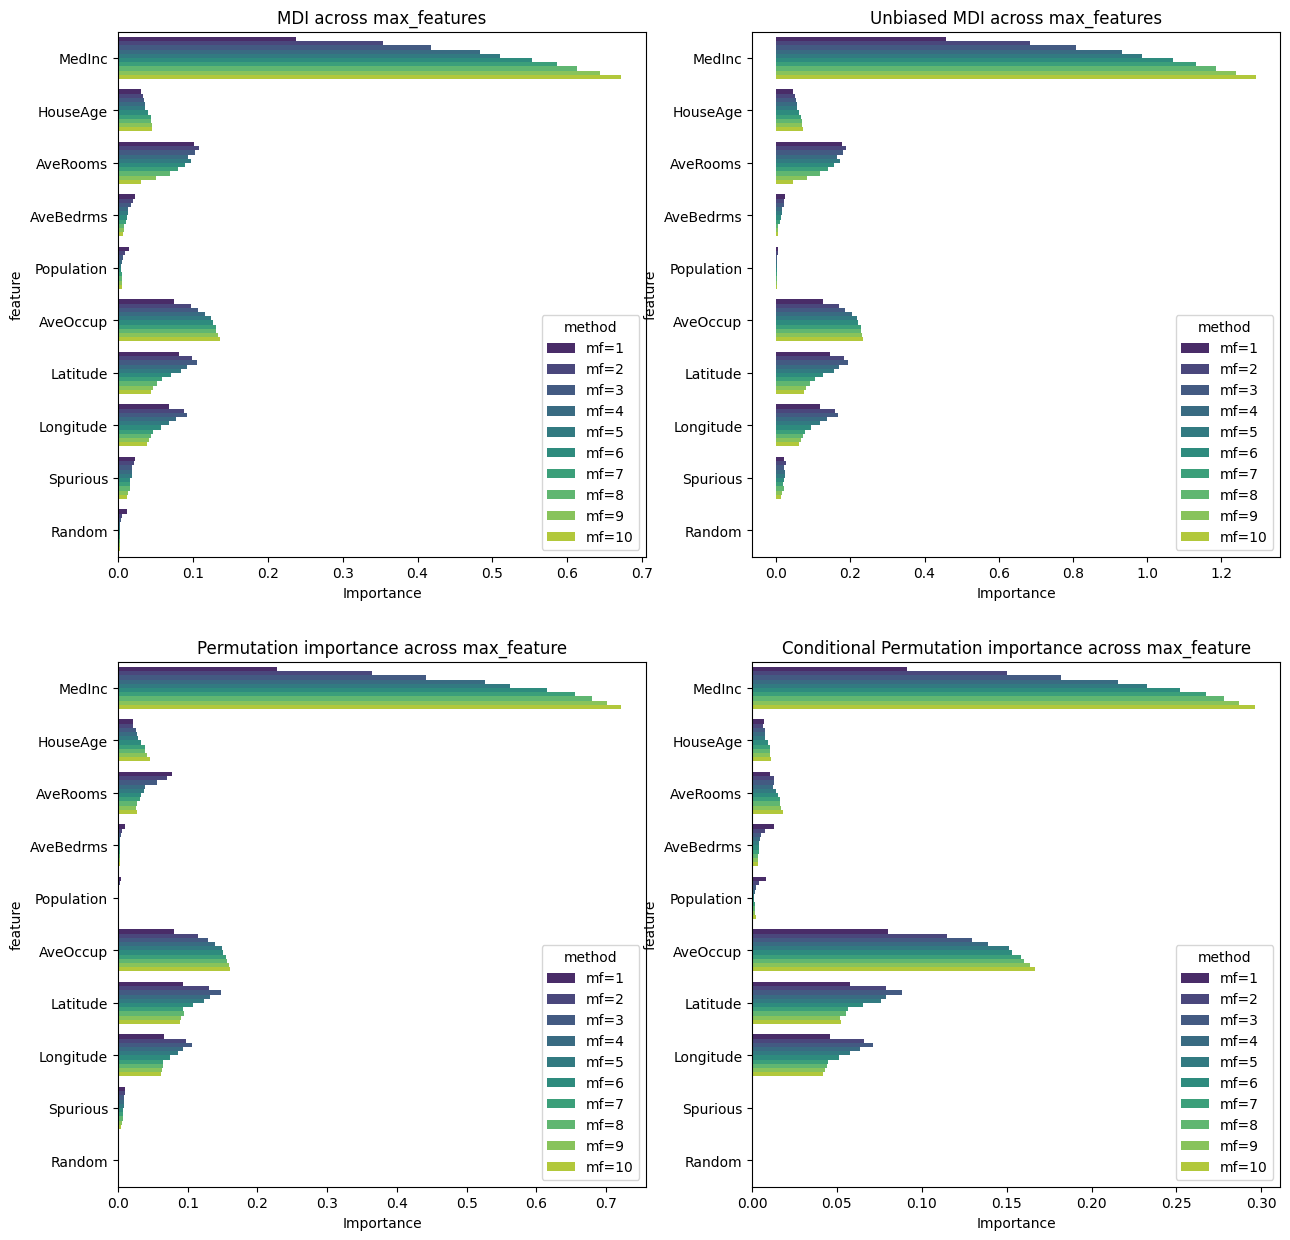

In [5]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
sns.barplot(
    data=df_val_mdi,
    x="mdi",
    y="feature",
    hue="method",
    errorbar=None,
    palette="viridis",
    ax=ax[0,0],
)
ax[0,0].set_title("MDI across max_features")
ax[0,0].set_xlabel("Importance")

sns.barplot(
    data=df_val_umdi,
    x="umdi",
    y="feature",
    hue="method",
    errorbar=None,
    palette="viridis",
    ax=ax[0,1],
)
ax[0,1].set_title("Unbiased MDI across max_features")
ax[0,1].set_xlabel("Importance")

sns.barplot(
    data=df_val_pfi,
    x="pfi",
    y="feature",
    hue="method",
    errorbar=None,
    palette="viridis",
    ax=ax[1,0],
)
ax[1,0].set_title("Permutation importance across max_feature")
ax[1,0].set_xlabel("Importance")

sns.barplot(
    data=df_val_cpi,
    x="cpi",
    y="feature",
    hue="method",
    errorbar=None,
    palette="viridis",
    ax=ax[1,1],
)
ax[1,1].set_title("Conditional Permutation importance across max_feature")
ax[1,1].set_xlabel("Importance")

# plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
sns.barplot(
    data=df_pval_gini,
    x="log_pval_umdi",
    y="feature",
    hue="method",
    palette="magma",
    ax=ax[0],
)
sns.barplot(
    data=df_pval_permut,
    x="log_pval_pi",
    y="feature",
    hue="method",
    palette="magma",
    ax=ax[1],
)
ax[0].axvline(x=-np.log10(pval_threshold), color="red", linestyle="--", label="Threshold")
ax[0].set_xlabel("-$\\log_{10}(pval)$")
ax[0].set_title("Significance of Feature Importance across max_features")
ax[1].axvline(x=-np.log10(pval_threshold), color="red", linestyle="--", label="Threshold")
ax[1].set_xlabel("-$\\log_{10}(pval)$")
ax[1].set_title("Significance of Feature Importance across max_features")
plt.tight_layout()
plt.show()


## Extrapolation bias in PFI
One of the main pitfalls of PFI is that it leads to extrapolation bias, i.e., it
forces the model to predict from regions of the feature space that are not present in
the training data. This can be seen on the california housing dataset, by comparing
the original latitude and longitude values with the permuted values. Indeed,
permuting the longitude values leads to generating combinations of latitude and
longitude that fall outside of the borders of California and therefore are by
definition not in the training data. This is not the case for the conditional
permutation that generates perturbed but reasonable values of longitude.



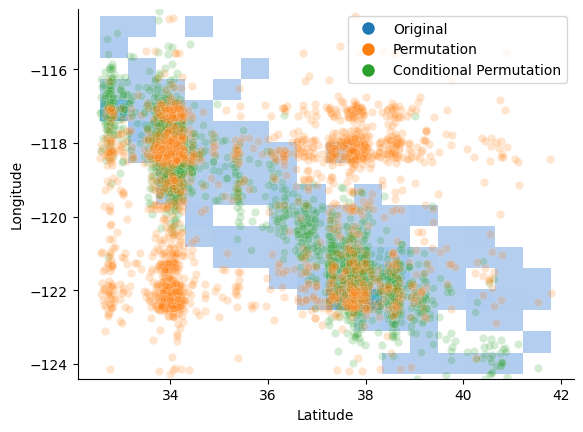

In [ ]:
X_train, X_test = train_test_split(
    X,
    test_size=0.3,
    random_state=random_seed,
)

conditional_sampler = ConditionalSampler(
    model_regression=RidgeCV(alphas=np.logspace(-3, 3, 5)),
    random_state=random_seed,
)


conditional_sampler.fit(X_train[:, :7], X_train[:, 7])
X_test_sample = conditional_sampler.sample(
    X_test[:, :7], X_test[:, 7], n_samples=1
).ravel()
# sphinx_gallery_thumbnail_number = 4
fig, ax = plt.subplots()

sns.histplot(
    x=X_test[:, 6],
    y=X_test[:, 7],
    color="tab:blue",
    ax=ax,
    alpha=0.9,
)
sns.scatterplot(
    x=X_test[:, 6],
    y=X_test_sample,
    ax=ax,
    alpha=0.2,
    c="tab:green",
)
sns.scatterplot(
    x=X_test[:, 6],
    y=rng.permutation(X_test[:, 7]),
    ax=ax,
    alpha=0.2,
    c="tab:orange",
)

legend_elements = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="tab:blue",
        markersize=10,
        label="Original",
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="tab:orange",
        markersize=10,
        label="Permutation",
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="tab:green",
        markersize=10,
        label="Conditional Permutation",
    ),
]
ax.legend(handles=legend_elements, loc="upper right")
ax.set_ylim(X[:, 7].min() - 0.1, X[:, 7].max() + 0.1)
sns.despine(ax=ax)
ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude")
plt.show()

PFI is likely to generate samples that are unrealistic and outside of the training
data, leading to extrapolation bias. In contrast, CPI generates samples that respect
the conditional distribution of the feature of interest.

